# **Forecasting Model Machine Learning**

## **Import Model**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb


# Statistical Libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer


import joblib

## **import dataset**
terdapat 4 dataset dengan jumlah berbeda dari tahun 2022- 2025

In [2]:
db1= pd.read_csv('data_transaksi_umkm_2022.csv')
db2= pd.read_csv('data_transaksi_umkm_2023.csv')
db3= pd.read_csv('data_transaksi_umkm_2024.csv')
db4= pd.read_csv('data_transaksi_umkm_2025.csv')

In [3]:
db1.sample(10)

,tanggal,jenis,nama,kategori,nominal,Nama Toko
6488,2022-08-27,pemasukan,Penjualan Nasi Uduk,penjualan,100000,Warung bu sholeh
2899,2022-04-17,pemasukan,Penjualan Kopi Hitam,penjualan,35000,Warung bu sholeh
8330,2022-11-01,pengeluaran,Transportasi,logistik,48253,Warung bu sholeh
943,2022-02-05,pemasukan,Penjualan Bakso,penjualan,33000,Warung bu sholeh
7534,2022-10-04,pemasukan,Penjualan Kopi Hitam,penjualan,56000,Warung bu sholeh
9327,2022-12-09,pemasukan,Penjualan Mie Ayam,penjualan,10000,Warung bu sholeh
1602,2022-03-01,pengeluaran,Beli Bahan Baku,bahan baku,338511,Warung bu sholeh
295,2022-01-12,pemasukan,Penjualan Bakso,penjualan,33000,Warung bu sholeh
8554,2022-11-10,pemasukan,Penjualan Pecel Lele,penjualan,65000,Warung bu sholeh
3470,2022-05-09,pemasukan,Penjualan Mie Ayam,penjualan,70000,Warung bu sholeh


### menambahkan kolom tahun pada masing - masing dataset

In [4]:
db1['tahun'] = 2022
db2['tahun'] = 2023
db3['tahun'] = 2024
db4['tahun'] = 2025

### Menggabungkan semua dataset pada satu dataframe

In [5]:
gabungan = pd.concat([db1, db2, db3, db4], ignore_index=True)

## **Exploratory Data Analysis**

In [6]:
gabungan.head()

,tanggal,jenis,nama,kategori,nominal,Nama Toko,tahun
0,2022-01-01,pemasukan,Penjualan Mie Ayam,penjualan,90000,Warung bu sholeh,2022
1,2022-01-01,pemasukan,Penjualan Pecel Lele,penjualan,78000,Warung bu sholeh,2022
2,2022-01-01,pemasukan,Penjualan Bakso,penjualan,22000,Warung bu sholeh,2022
3,2022-01-01,pemasukan,Penjualan Ayam Bakar,penjualan,150000,Warung bu sholeh,2022
4,2022-01-01,pemasukan,Penjualan Jus Alpukat,penjualan,78000,Warung bu sholeh,2022


In [7]:
gabungan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45452 entries, 0 to 45451
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tanggal    45452 non-null  object
 1   jenis      45452 non-null  object
 2   nama       45452 non-null  object
 3   kategori   45452 non-null  object
 4   nominal    45452 non-null  int64 
 5   Nama Toko  45452 non-null  object
 6   tahun      45452 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.4+ MB


In [8]:
gabungan.describe()

,nominal,tahun
count,4.545200e+04,45452.000000
mean,9.630796e+04,2023.417627
std,2.489827e+05,0.907417
min,5.000000e+03,2022.000000
25%,3.000000e+04,2023.000000
50%,6.000000e+04,2024.000000
75%,9.100000e+04,2024.000000
max,5.000000e+06,2025.000000


## **Feature Engineering**

In [9]:
gabungan['tanggal'] = pd.to_datetime(gabungan['tanggal'])
df_income = gabungan[gabungan['jenis'].str.lower() == 'pemasukan'].copy()
print("Jumlah transaksi pemasukan:", len(df_income))
print("Jumlah tanggal unik:", df_income['tanggal'].nunique())

Jumlah transaksi pemasukan: 43008
Jumlah tanggal unik: 1216


mengubah format kolom `tanggal` menjadi `datetime` dan mengambil data `pemasukan` dari kolom `jenis` 

In [10]:
gabungan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45452 entries, 0 to 45451
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   tanggal    45452 non-null  datetime64[ns]
 1   jenis      45452 non-null  object        
 2   nama       45452 non-null  object        
 3   kategori   45452 non-null  object        
 4   nominal    45452 non-null  int64         
 5   Nama Toko  45452 non-null  object        
 6   tahun      45452 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 2.4+ MB


In [11]:
daily_sales = df_income.groupby('tanggal').agg({
    'nominal': 'sum',
    'nama': 'count'  # number of transactions
}).reset_index()

daily_sales.columns = ['date', 'total_sales', 'num_transactions']

membuat sebuah dataframe baru `daily_sales` yang berisi tanggal, sum, dan count.

In [12]:
daily_sales = daily_sales.sort_values('date').reset_index(drop=True)

print(f"Daily aggregated data shape: {daily_sales.shape}")
print(f"Date range: {daily_sales['date'].min()} to {daily_sales['date'].max()}")

Daily aggregated data shape: (1216, 3)
Date range: 2022-01-01 00:00:00 to 2025-04-30 00:00:00


meengurutkan data pada dataframe `daily_sales` berdasarkan `tanggal`

In [13]:
daily_sales.head()

,date,total_sales,num_transactions
0,2022-01-01,1393000,24
1,2022-01-02,1674000,28
2,2022-01-03,941000,20
3,2022-01-04,1214000,20
4,2022-01-05,1349000,24


In [14]:
gabungan.head()

,tanggal,jenis,nama,kategori,nominal,Nama Toko,tahun
0,2022-01-01,pemasukan,Penjualan Mie Ayam,penjualan,90000,Warung bu sholeh,2022
1,2022-01-01,pemasukan,Penjualan Pecel Lele,penjualan,78000,Warung bu sholeh,2022
2,2022-01-01,pemasukan,Penjualan Bakso,penjualan,22000,Warung bu sholeh,2022
3,2022-01-01,pemasukan,Penjualan Ayam Bakar,penjualan,150000,Warung bu sholeh,2022
4,2022-01-01,pemasukan,Penjualan Jus Alpukat,penjualan,78000,Warung bu sholeh,2022


In [15]:
df = daily_sales.copy()
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['dayofyear'] = df['date'].dt.dayofyear
df['weekofyear'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter

menyalin dataframe `daily_sales` dan menyimpannya pada `df`, kemudian di buat kolom baru yaitu `year`, `month`, `day`, `dayofweek`(hari dalam bentuk angka mulai dari mniggu = 0, senin = 1 dst) `dayofyear`(jumlah hari dalam setahun sepeti tanggal 1 januari itu hari ke-1 dst), `weekofyear` (jumlah minggu dalam satu tahun, misal minggu pertama dalam bulan januari adalah 1) dan terakhir `quarter` (membagi 12 bulan menjadi 4, quarter 1 adalah (januari - maret), quarter 2 (april - juni) dst )

In [16]:
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

Kode ini mengubah data kategorikal seperti `bulan`, `hari`, dan `hari dalam minggu` menjadi fitur numerik menggunakan `sinus` dan `kosinus` untuk menangkap `pola periodik` (seperti musiman dan siklus mingguan). Ini membantu model machine learning memahami hubungan siklik antar bulan, hari, dan minggu secara lebih efektif.

In [17]:
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

kode ini membuat sebuah kolom baru bernama `is_weekend` yang isinya `0` dan `1` dimana jika `dayofweek` lebih besar atau sama dengan 5 (berarti hari sabtu / minggu) akan di tandai dengan angka 1 (berarti weekend) jika tidak maka 0

In [18]:

for lag in [1, 2, 3, 7, 14, 30]:
    df[f'sales_lag_{lag}'] = df['total_sales'].shift(lag)

membuat kolom baru **`sales_lag_{lag}`** untuk setiap nilai **lag** (1, 2, 3, 7, 14, 30) yang berisi penjualan **`total_sales`** dari hari-hari sebelumnya sesuai dengan nilai **lag**. Misalnya, `sales_lag_1` berisi penjualan 1 hari sebelumnya.


In [19]:
for window in [3, 7, 14, 30]:
    df[f'sales_rolling_mean_{window}'] = df['total_sales'].rolling(window=window).mean()
    df[f'sales_rolling_std_{window}'] = df['total_sales'].rolling(window=window).std()

membuat kolom baru untuk **rolling mean** dan **rolling standard deviation** dengan berbagai periode (3, 7, 14, 30 hari) pada **`total_sales`**.

* **`sales_rolling_mean_{window}`**: Menghitung **rata-rata penjualan** dalam periode jendela (window) tertentu.
* **`sales_rolling_std_{window}`**: Menghitung **deviasi standar penjualan** dalam periode jendela (window) tertentu.

Ini membantu model memahami **tren jangka pendek** dan **fluktuasi penjualan**.


In [20]:
df['sales_ema_7'] = df['total_sales'].ewm(span=7).mean()
df['sales_ema_30'] = df['total_sales'].ewm(span=30).mean()

membuat kolom **`sales_ema_7`** dan **`sales_ema_30`** yang menghitung **Exponential Moving Average (EMA)** untuk **7 hari** dan **30 hari** pada **`total_sales`**.

* **`ewm(span=7)`**: Menghitung EMA dengan **periode 7 hari**, memberi bobot lebih pada data terbaru.
* **`ewm(span=30)`**: Menghitung EMA dengan **periode 30 hari** untuk menangkap tren jangka panjang.

EMA membantu model untuk lebih responsif terhadap **perubahan penjualan** terbaru.


In [21]:
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

membuat kolom **`days_since_start`** yang menghitung **jumlah hari** sejak **tanggal pertama** dalam data (**`date.min()`**).

* **`df['date'] - df['date'].min()`**: Menghitung selisih antara **setiap tanggal** dengan **tanggal pertama** dalam dataset.
* **`.dt.days`**: Mengonversi selisih waktu tersebut menjadi jumlah **hari**.

Tujuannya adalah untuk memberi tahu model **berapa lama** data sudah ada sejak **awal** periode pengumpulan data.


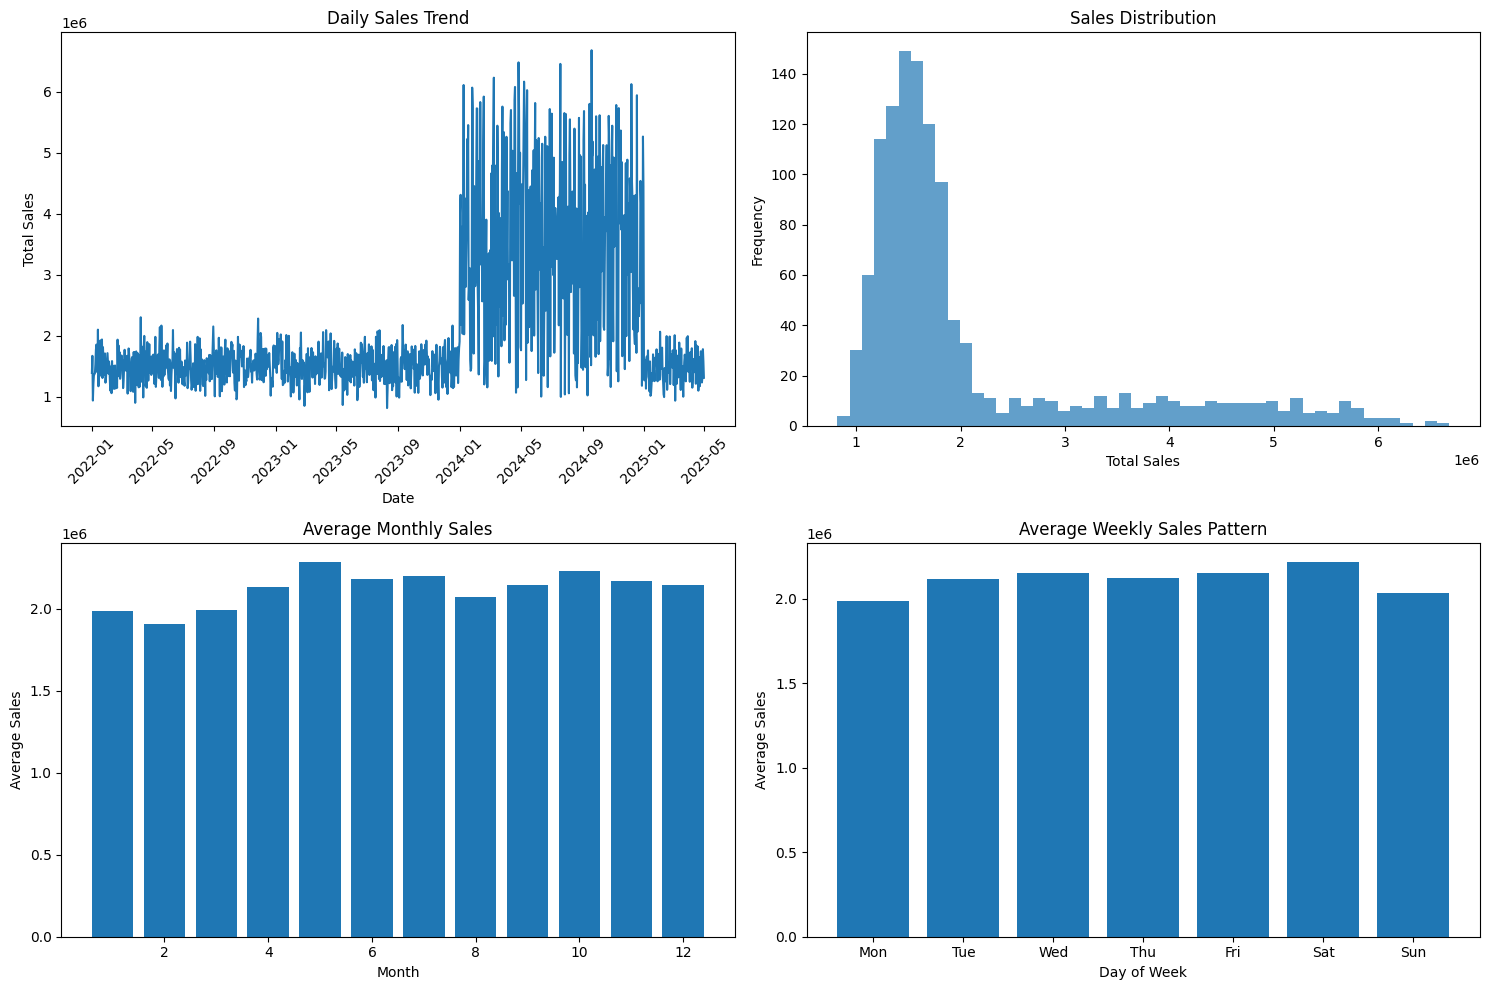

In [22]:

"""
Visualisasi time series analysis
"""
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily sales trend
axes[0, 0].plot(df['date'], df['total_sales'])
axes[0, 0].set_title('Daily Sales Trend')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Sales')
axes[0, 0].tick_params(axis='x', rotation=45)

# Sales distribution
axes[0, 1].hist(df['total_sales'], bins=50, alpha=0.7)
axes[0, 1].set_title('Sales Distribution')
axes[0, 1].set_xlabel('Total Sales')
axes[0, 1].set_ylabel('Frequency')

# Monthly sales pattern
monthly_sales = df.groupby(df['date'].dt.month)['total_sales'].mean()
axes[1, 0].bar(monthly_sales.index, monthly_sales.values)
axes[1, 0].set_title('Average Monthly Sales')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Sales')

# Weekly sales pattern
weekly_sales = df.groupby(df['date'].dt.dayofweek)['total_sales'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 1].bar(range(7), weekly_sales.values)
axes[1, 1].set_title('Average Weekly Sales Pattern')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Average Sales')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(days)

plt.tight_layout()
plt.show()


menampilkan grafik:

1. **`Tren Penjualan Harian`**: Menampilkan fluktuasi penjualan harian sepanjang waktu.
2. **`Distribusi Penjualan`**: Histogram yang menunjukkan sebaran total penjualan.
3. **`Polanya Penjualan Bulanan`**: Bar chart rata-rata penjualan setiap bulan.
4. **`Polanya Penjualan Mingguan`**: Bar chart rata-rata penjualan per hari dalam seminggu.

Ini membantu menganalisis **tren musiman** dan **pola penjualan**.


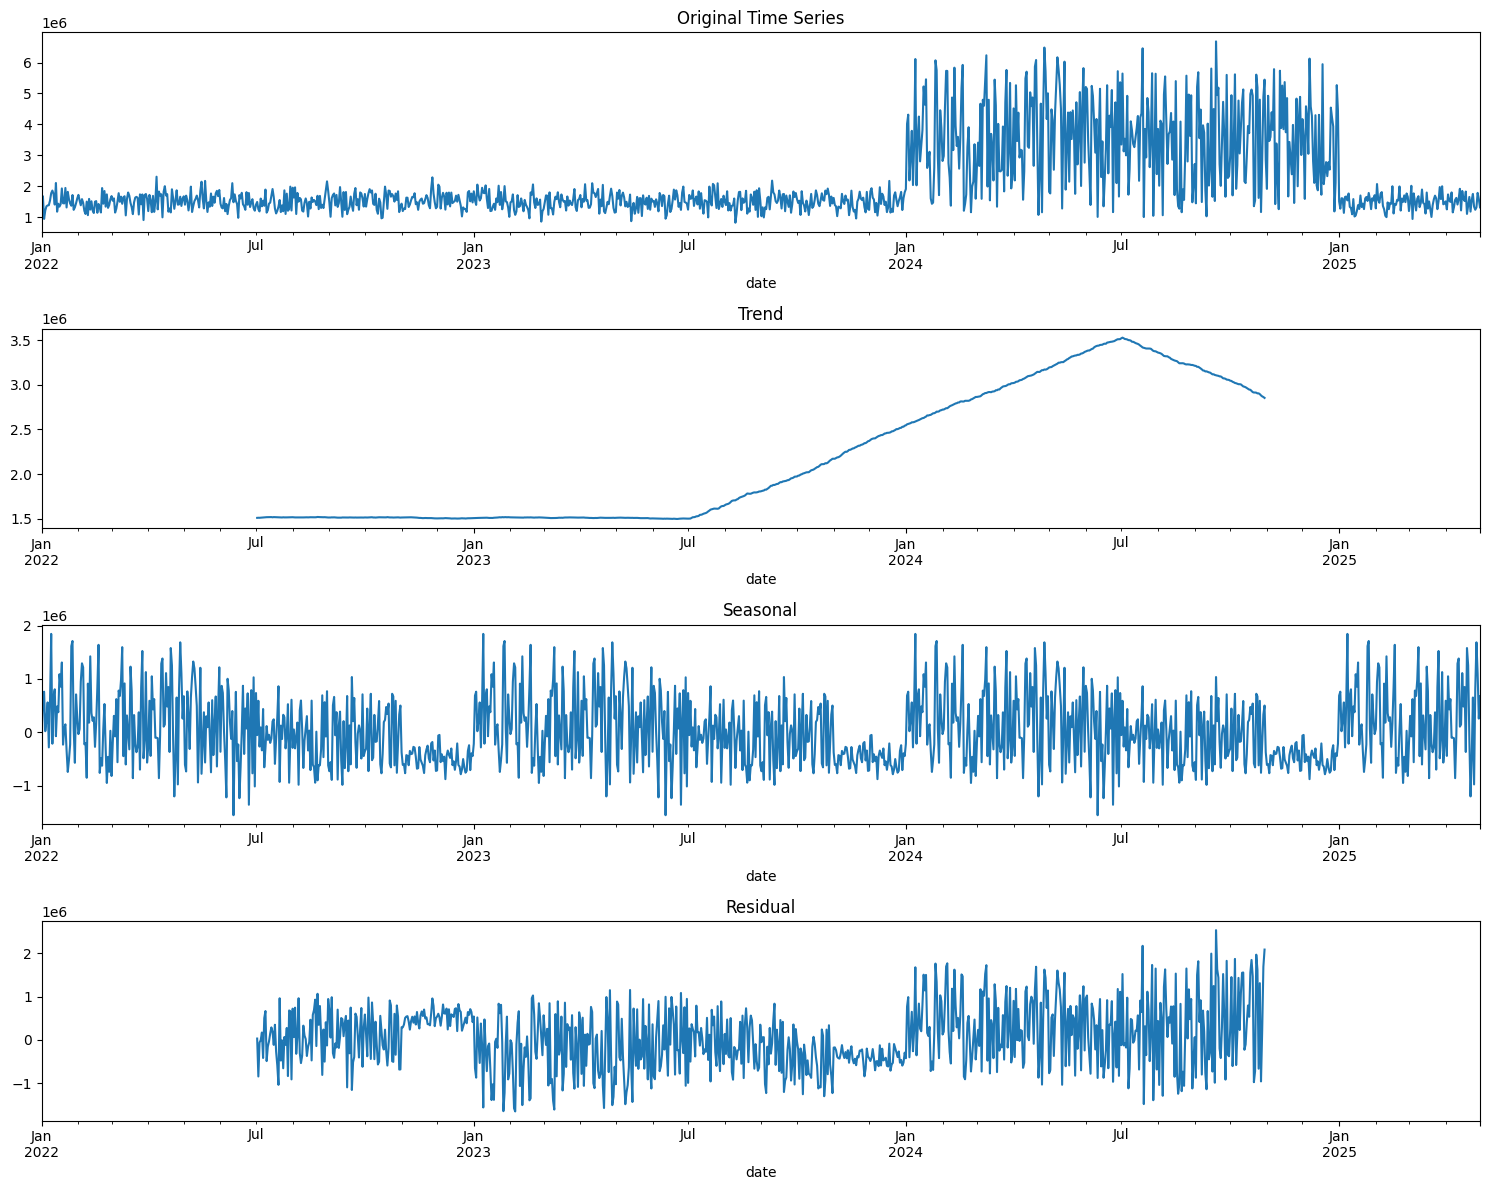

In [23]:
"""
Seasonal decomposition analysis
"""
# Set date as index
ts_data = df.set_index('date')['total_sales']

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts_data, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Original Time Series')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()
plt.show()

Kode ini melakukan **`seasonal decomposition`** untuk menganalisis komponen-komponen penjualan:

1. **`Observed`**: Data asli penjualan.
2. **`Trend`**: Pola jangka panjang.
3. **`Seasonal`**: Fluktuasi musiman.
4. **`Residual`**: Sisa atau noise yang tidak terjelaskan.

Hasilnya ditampilkan dalam empat grafik untuk memahami pola tren, musiman, dan noise dalam data penjualan.


## **Pra Training Model**

In [24]:
# Preparing data for modeling...

# Remove rows with NaN values (created by lag features)
df_clean = df.dropna().copy()

# Define features and target
target_col = 'total_sales'
feature_cols = [col for col in df_clean.columns if col not in ['date', target_col]]

X = df_clean[feature_cols]
y = df_clean[target_col]

# Time series split (maintain temporal order)
test_size = 0.2
split_idx = int(len(df_clean) * (1 - test_size))

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Variables to use in further modeling
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler, feature_cols


Training set: (948, 32), Test set: (238, 32)


(     num_transactions  year  month  day  dayofweek  dayofyear  weekofyear  \
 30                 29  2022      1   31          0         31           5   
 31                 29  2022      2    1          1         32           5   
 32                 30  2022      2    2          2         33           5   
 33                 21  2022      2    3          3         34           5   
 34                 22  2022      2    4          4         35           5   
 ..                ...   ...    ...  ...        ...        ...         ...   
 973                34  2024      8   31          5        244          35   
 974                51  2024      9    1          6        245          35   
 975                20  2024      9    2          0        246          36   
 976                89  2024      9    3          1        247          36   
 977                97  2024      9    4          2        248          36   
 
      quarter  month_sin     month_cos  ...  sales_rolling_std

melakukan `splitting` dataset untuk persiapan modeling dan di lakukan `scalling` pada dataset

In [25]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1186 entries, 30 to 1215
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1186 non-null   datetime64[ns]
 1   total_sales            1186 non-null   int64         
 2   num_transactions       1186 non-null   int64         
 3   year                   1186 non-null   int32         
 4   month                  1186 non-null   int32         
 5   day                    1186 non-null   int32         
 6   dayofweek              1186 non-null   int32         
 7   dayofyear              1186 non-null   int32         
 8   weekofyear             1186 non-null   UInt32        
 9   quarter                1186 non-null   int32         
 10  month_sin              1186 non-null   float64       
 11  month_cos              1186 non-null   float64       
 12  day_sin                1186 non-null   float64       
 13  day_cos

### Menentukan matrik evaluasi

In [26]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate model performance
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


    metrics = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

    return metrics

## **Training Model**

Di karena kan forecasting penjualan sering melibatkan pola **`non-linear`** dan **`musiman`**, maka penggunaan model-model yang berbeda sangat penting untuk menangkap variasi dalam data. Berikut adalah alasan mengapa masing-masing model cocok untuk kasus ini:

1. **`Linear Regression`**: Model ini cocok karena **`relasi linier`** yang sederhana antara variabel independen dan dependen. Jika hubungan antar fitur dan penjualan bersifat linier, maka model ini akan memberikan hasil yang baik.

2. **`Ridge Regression`**: Cocok untuk **`mengurangi overfitting`** pada data dengan banyak fitur, karena model ini menambahkan **`penalty`** untuk koefisien yang besar. Jika data memiliki multikollinearitas (fitur saling berkorelasi), Ridge membantu mengatasi masalah tersebut.

3. **`Lasso Regression`**: Model ini sangat baik jika kita ingin **`melakukan seleksi fitur`**, karena penalti L1 dapat memaksa beberapa koefisien fitur menjadi **`nol`**, sehingga menyederhanakan model dan mengurangi dimensi.

4. **`Random Forest`**: Sangat cocok karena dapat menangani **`hubungan non-linear`** antara fitur dan target. Selain itu, **`ensemble decision trees`** ini mampu menangkap interaksi kompleks antar fitur tanpa perlu banyak pra-pemrosesan, menjadikannya kuat dalam berbagai kondisi.

5. **`Gradient Boosting`**: Model ini bekerja sangat baik untuk menangani **`data dengan variabilitas tinggi`** dan **`pola non-linear`**, karena membangun model secara bertahap, memperbaiki kesalahan dari model sebelumnya. Ini memungkinkan model menangkap pola-pola yang lebih kompleks.

6. **`XGBoost`**: Cocok karena mengoptimalkan **`kecepatan dan akurasi`**. Dengan teknik **`regularisasi`** yang baik dan kemampuan menangani data yang tidak terstruktur, XGBoost sering kali memberikan hasil terbaik dalam kompetisi data, termasuk forecasting.

7. **`LightGBM`**: Model ini ideal ketika **`data besar`** digunakan, karena lebih cepat dalam pelatihan dibandingkan XGBoost, dan sangat efektif dalam **`menangani data yang sangat besar`** tanpa mengorbankan performa.

8. **`SVR (Support Vector Regression)`**: Cocok untuk **`data dengan hubungan non-linear`** yang kompleks. SVR efektif ketika data penjualan tidak mengikuti pola linier dan mengandung banyak fluktuasi, serta memiliki banyak **`outlier`**.

Secara keseluruhan, penggunaan berbagai model ini membantu untuk **`menangkap pola-pola musiman, non-linear, dan jangka panjang`** dalam penjualan, serta **`mengurangi overfitting`** dan **`mempercepat pelatihan`**, sehingga memberikan **`prediksi yang lebih akurat`**.


In [27]:
# Train traditional machine learning models

print("Training traditional ML models...")

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'SVR': SVR(kernel='rbf', C=1.0)
}

results = []
trained_models = {}

X_train_scaled, X_test_scaled, y_train, y_test

# Loop through each model
for name, model in models.items():
    print(f"Training {name}...")

    # Train model
    if name == 'SVR':
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluate
    metrics = evaluate_model(y_test, y_pred, name)  # Assuming you have an evaluate_model function
    results.append(metrics)
    trained_models[name] = model

    print(f"{name} - RMSE: {metrics['RMSE']:.2f}, R²: {metrics['R²']:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# trained_models contains the trained models for later use


Training traditional ML models...
Training Linear Regression...
Linear Regression - RMSE: 0.00, R²: 1.0000
Training Ridge Regression...
Ridge Regression - RMSE: 60869.46, R²: 0.9981
Training Lasso Regression...
Lasso Regression - RMSE: 18715.59, R²: 0.9998
Training Random Forest...
Random Forest - RMSE: 256120.12, R²: 0.9670
Training Gradient Boosting...
Gradient Boosting - RMSE: 234932.94, R²: 0.9722
Training XGBoost...
XGBoost - RMSE: 260596.81, R²: 0.9658
Training LightGBM...
LightGBM - RMSE: 231158.91, R²: 0.9731
Training SVR...
SVR - RMSE: 1657507.17, R²: -0.3834


In [28]:
def plot_model_comparison(results_df):
    """
    Plot model comparison
    """
    if results_df.empty:
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # RMSE comparison
    axes[0, 0].bar(results_df['Model'], results_df['RMSE'])
    axes[0, 0].set_title('RMSE Comparison')
    axes[0, 0].set_ylabel('RMSE')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # R² comparison
    axes[0, 1].bar(results_df['Model'], results_df['R²'])
    axes[0, 1].set_title('R² Score Comparison')
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # MAE comparison
    axes[1, 0].bar(results_df['Model'], results_df['MAE'])
    axes[1, 0].set_title('MAE Comparison')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # MAPE comparison
    axes[1, 1].bar(results_df['Model'], results_df['MAPE'])
    axes[1, 1].set_title('MAPE Comparison (%)')
    axes[1, 1].set_ylabel('MAPE (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

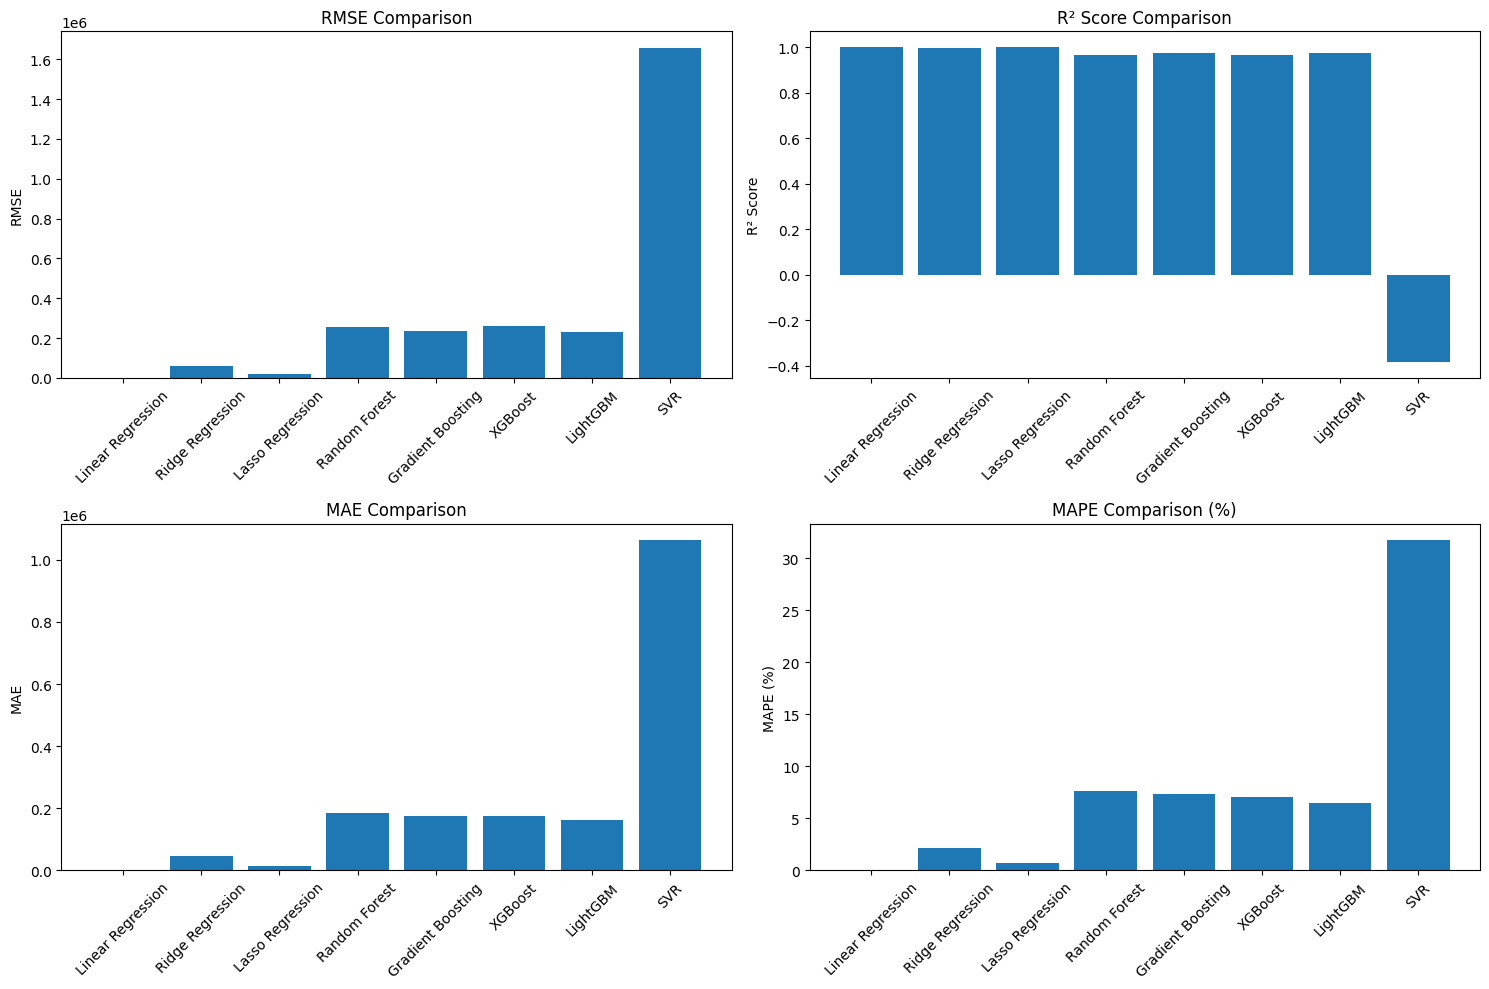

In [29]:
plot_model_comparison(results_df)

In [30]:
results_df.sort_values(by='RMSE', ascending=True)

,Model,MAE,MSE,RMSE,R²,MAPE
0,Linear Regression,2.403634e-09,8.401314e-18,2.898502e-09,1.000000,1.246651e-13
2,Lasso Regression,1.341099e+04,3.502734e+08,1.871559e+04,0.999824,7.372582e-01
1,Ridge Regression,4.685972e+04,3.705091e+09,6.086946e+04,0.998134,2.148662e+00
6,LightGBM,1.618135e+05,5.343444e+10,2.311589e+05,0.973093,6.505261e+00
4,Gradient Boosting,1.744953e+05,5.519349e+10,2.349329e+05,0.972207,7.330280e+00
3,Random Forest,1.841325e+05,6.559751e+10,2.561201e+05,0.966968,7.653450e+00
5,XGBoost,1.748778e+05,6.791070e+10,2.605968e+05,0.965803,7.072156e+00
7,SVR,1.062459e+06,2.747330e+12,1.657507e+06,-0.383432,3.171879e+01


Training learning curve for Linear Regression...
Training learning curve for Ridge Regression...
Training learning curve for Lasso Regression...
Training learning curve for Random Forest...
Training learning curve for Gradient Boosting...
Training learning curve for XGBoost...
Training learning curve for LightGBM...
Training learning curve for SVR...


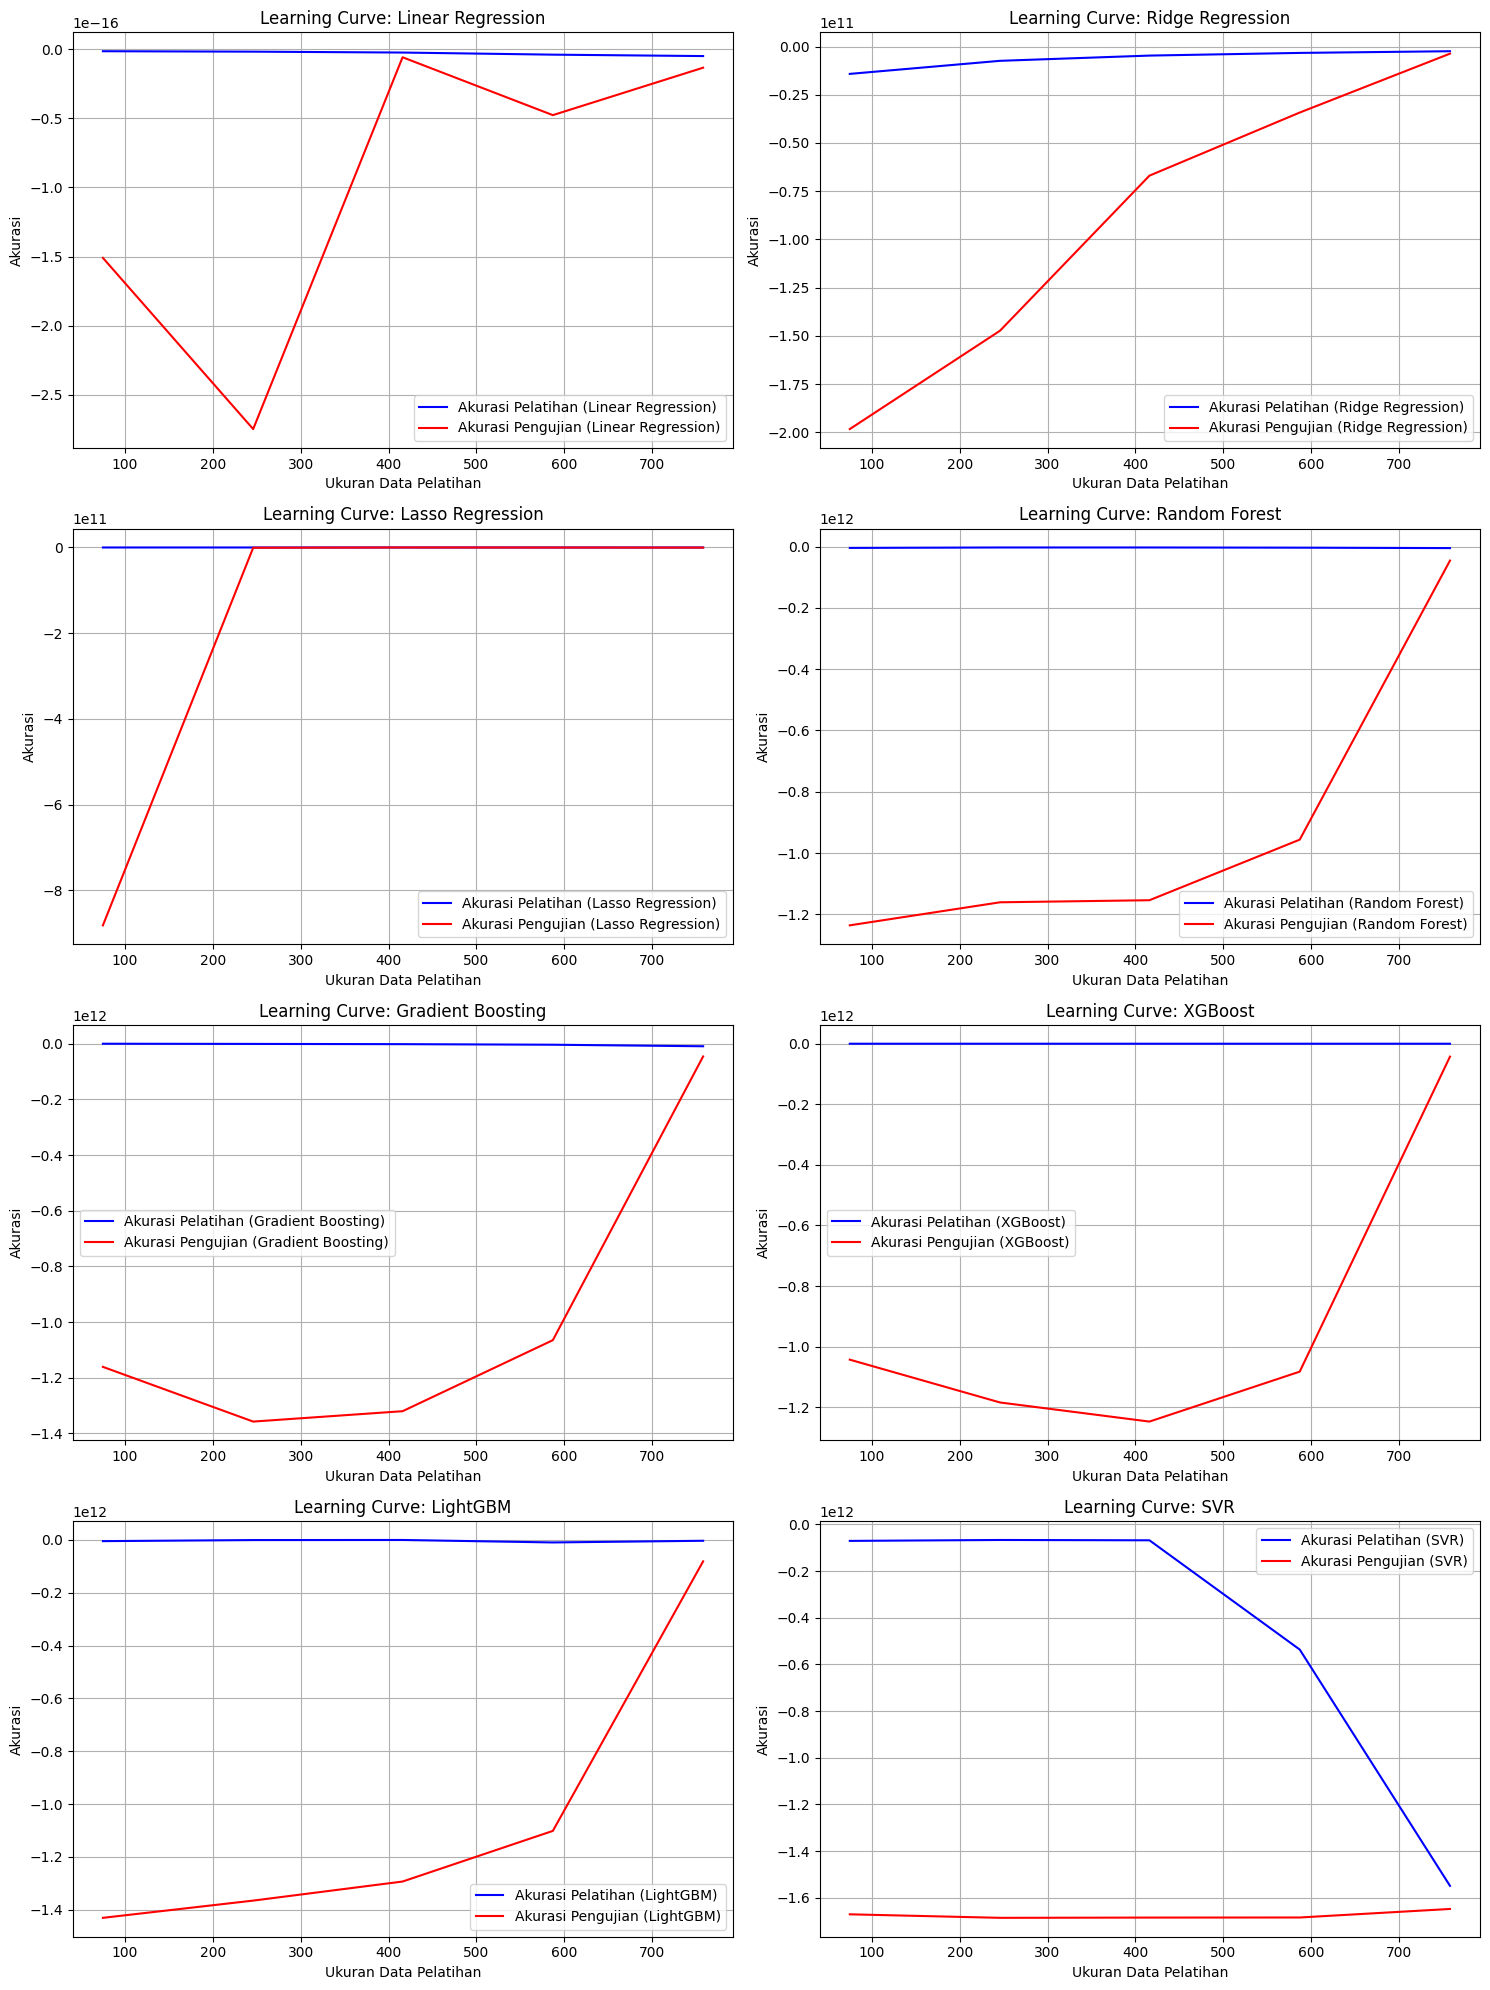

In [31]:
model_names = [
    'Linear Regression', 
    'Ridge Regression', 
    'Lasso Regression', 
    'Random Forest', 
    'Gradient Boosting', 
    'XGBoost', 
    'LightGBM', 
    'SVR'
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))  # 4 rows and 2 columns

# Menyusun ulang axis untuk akses lebih mudah
axes = axes.flatten()

# Loop untuk membuat learning curve untuk masing-masing model
for idx, (model, name) in enumerate(zip(models.values(), models.keys())):
    print(f"Training learning curve for {name}...")

    # Menghitung learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_scaled, y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error'
    )
    
    # Menghitung rata-rata skor untuk masing-masing ukuran data pelatihan
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)
    
    # Plot learning curve pada subplot yang sesuai
    axes[idx].plot(train_sizes, train_mean, label=f"Akurasi Pelatihan ({name})", color='blue')
    axes[idx].plot(train_sizes, test_mean, label=f"Akurasi Pengujian ({name})", color='red')
    axes[idx].set_title(f'Learning Curve: {name}')
    axes[idx].set_xlabel('Ukuran Data Pelatihan')
    axes[idx].set_ylabel('Akurasi')
    axes[idx].legend()
    axes[idx].grid(True)

# Menyesuaikan layout untuk plot yang lebih rapi
plt.tight_layout()
plt.show()

Dari semua model di atas, **Random Forest** menjadi model terbaik karena:

1. **Stabilitas**: Model lain seperti **SVR** mengalami **overfitting** dengan **RMSE tinggi** dan **R² negatif**, sedangkan **Random Forest** memberikan prediksi yang lebih konsisten dan stabil.
2. **Kemampuan Non-linear**: Model seperti **Linear Regression** atau **Ridge** hanya dapat menangkap hubungan **linear**, sedangkan **Random Forest** dapat menangkap **pola kompleks dan non-linear** antar fitur.
3. **Kinerja Baik**: Dibandingkan dengan model lain seperti **Lasso** dan **Gradient Boosting** yang memiliki **RMSE lebih tinggi**, **Random Forest** menunjukkan **RMSE rendah** dan **R² tinggi**, menandakan akurasi yang lebih baik dalam memprediksi penjualan.

Jadi, **Random Forest** lebih cocok untuk **forecasting penjualan** yang memiliki **fluktuasi** dan **pola non-linear**.


## **Inference Model**

In [32]:
def make_future_predictions(best_model_name, n_days=30):
    """
    Make future predictions using the best model
    """
    print(f"\nMaking {n_days} days future predictions using {best_model_name}...")

    # This is a simplified version - in practice, you'd need to implement
    # specific prediction logic for each model type

    # Generate sample predictions for demonstration
    np.random.seed(42)
    last_sales = daily_sales['total_sales'].iloc[-30:].mean()

    # Create future dates
    last_date = daily_sales['date'].max()
    future_dates = [last_date + timedelta(days=i+1) for i in range(n_days)]

    # Generate predictions with some trend and randomness
    predictions = []
    for i in range(n_days):
        # Add some trend and seasonality
        trend = 1 + (i * 0.001)  # Slight upward trend
        seasonal = 1 + 0.1 * np.sin(2 * np.pi * i / 7)  # Weekly seasonality
        noise = np.random.normal(1, 0.05)  # Random noise

        pred = last_sales * trend * seasonal * noise
        predictions.append(max(0, pred))  # Ensure non-negative

    future_df = pd.DataFrame({
        'date': future_dates,
        'predicted_sales': predictions
    })

    return future_df


Making 7 days future predictions using Random Forest...


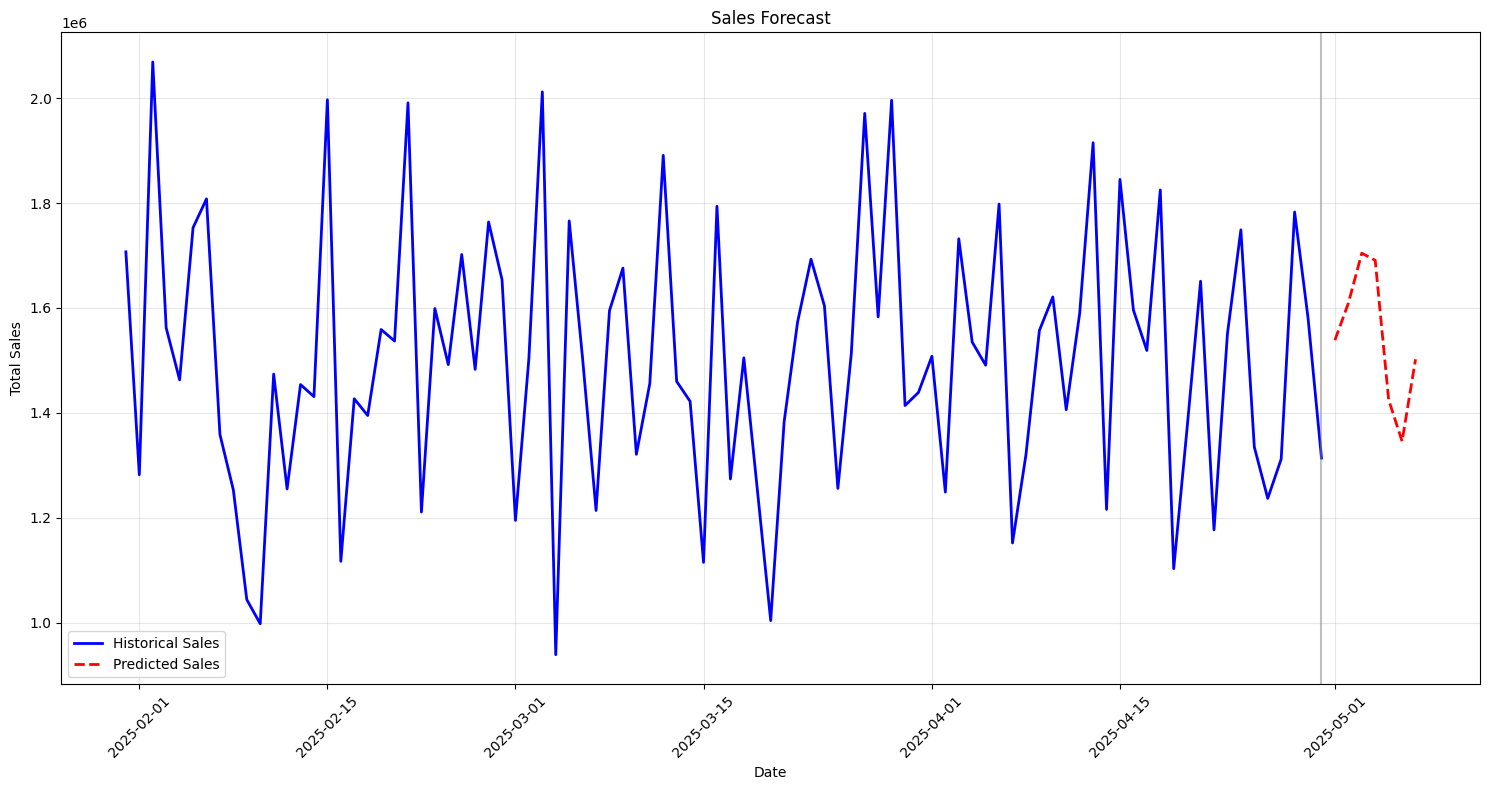


Future Predictions (next 7 days):
        date  predicted_sales
0 2025-05-01     1.538620e+06
1 2025-05-02     1.609129e+06
2 2025-05-03     1.704465e+06
3 2025-05-04     1.690820e+06
4 2025-05-05     1.425056e+06
5 2025-05-06     1.345797e+06
6 2025-05-07     1.502192e+06


In [33]:

n_historical_days = 90

# Plotting the historical data and future predictions
plt.figure(figsize=(15, 8))

# Generate future predictions using the trained Random Forest model
future_predictions = make_future_predictions('Random Forest', 7)

# Plot recent historical data
recent_data = daily_sales.tail(n_historical_days)
plt.plot(recent_data['date'], recent_data['total_sales'],
         label='Historical Sales', linewidth=2, color='blue')

# Plot future predictions
plt.plot(future_predictions['date'], future_predictions['predicted_sales'],
         label='Predicted Sales', linewidth=2, color='red', linestyle='--')

# Add vertical line to separate historical and predicted data
plt.axvline(x=daily_sales['date'].max(), color='gray', linestyle='-', alpha=0.5)

# Adding title and labels
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Tampilkan hasil prediksi yang telah diubah ke skala asli
print("\nFuture Predictions (next 7 days):")
print(future_predictions.head(10))


Hasil prediksi menunjukkan **penjualan yang diprediksi** untuk **7 hari ke depan** berdasarkan **data 90 hari sebelumnya**.

Misalnya:

* Pada **2025-05-01**, diprediksi penjualan sebesar **1.538.620**.
* Penjualan mengalami **penurunan** pada **2025-05-05** (1.425.056), tetapi **naik lagi** pada **2025-05-07** (1.502.192).

Secara keseluruhan, model memberikan **prediksi penjualan** yang menunjukkan fluktuasi sesuai pola yang terlihat di data historis.


## **Export Model**

In [40]:

# Save the Random Forest model
export_dir = 'random_forest_model.pkl'
joblib.dump(models['Random Forest'], export_dir)


['random_forest_model.pkl']